# Braces Detection and Removal using Mask R-CNN

This script implements a complete pipeline for detecting and removing braces from dental images
using a pre-trained Mask R-CNN model fine-tuned on custom braces annotations.

The pipeline includes:
1. Custom dataset class for braces annotations
2. Model architecture setup and training
3. Inference and visualization
4. Image inpainting for braces removal

In [2]:
import os
import torch
import torch.utils.data
import numpy as np
import cv2
import json
from PIL import Image

## Dataset Class Definition

The Dataset class handles loading images and their corresponding JSON annotations
from LabelMe format. It creates binary masks from polygon annotations and prepares
the data in the format expected by PyTorch's Mask R-CNN implementation.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        """
        Initialize the dataset.
        
        Args:
            images_dir (str): Directory containing the training images
            labels_dir (str): Directory containing the JSON annotation files
            transforms: Optional transforms to apply to images and targets
        """
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_dir))
        self.label_files = sorted(os.listdir(labels_dir))

    def __len__(self):
        """Return the number of labeled images in the dataset."""
        return len(self.label_files)  # only images with labels

    def __getitem__(self, idx):
        """
        Load a single training sample.
        
        Args:
            idx (int): Index of the sample to load
            
        Returns:
            tuple: (image_tensor, target_dict) where target_dict contains masks,
                   bounding boxes, labels, and other metadata
        """
        # Load image
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        # Load annotation polygon
        label_path = os.path.join(self.labels_dir, self.label_files[idx])
        with open(label_path) as f:
            label = json.load(f)

        # Create mask from polygons
        masks = []
        for shape in label['shapes']:
            if shape['label'].lower() == 'braces':
                points = np.array(shape['points'], dtype=np.int32)
                mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
                cv2.fillPoly(mask, [points], 1)
                masks.append(mask)

        if len(masks) == 0:
            # No braces in this image
            masks = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        else:
            masks = np.stack(masks)

        # Convert everything to torch tensors
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        # For single instance, target is mask and bounding box
        target = {}
        target["masks"] = masks

        # Bounding boxes for each mask
        boxes = []
        for mask in masks:
            pos = torch.where(mask)
            xmin = torch.min(pos[1])
            xmax = torch.max(pos[1])
            ymin = torch.min(pos[0])
            ymax = torch.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)

        # Labels (1 for braces)
        target["labels"] = torch.ones((len(boxes),), dtype=torch.int64)

        # Image id
        target["image_id"] = torch.tensor([idx])

        # Areas (bbox area)
        area = (target["boxes"][:, 3] - target["boxes"][:, 1]) * (target["boxes"][:, 2] - target["boxes"][:, 0])
        target["area"] = area

        # Iscrowd
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        # Convert image to tensor
        img = torch.as_tensor(img.transpose(2, 0, 1), dtype=torch.float32) / 255.0

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

## Model Architecture Setup

In [19]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
# Initialize the dataset
dataset = Dataset(
    images_dir="./braces",
    labels_dir="./labels",
    transforms=None  # add augmentations here if you want
)

In [17]:
len(dataset.image_files)

611

In [16]:
len(dataset.label_files)

611

Check if the length of both are equal to ensure each image file has a corresponding label file

In [15]:
assert len(dataset.image_files) == len(dataset.label_files), "Mismatch between images and labels!"

Create a data loader for training

In [18]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

Load the pre-trained model

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

In [ ]:
# Get number of input features for classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one (2 classes: background and braces)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

# Now get number of input features for mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

# And replace mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

## Training

In [ ]:
import torch.optim as optim

In [ ]:
# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Set the number of epochs

In [ ]:
num_epochs = 10

Run training loop

In [ ]:
for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Iter {i}, Loss: {losses.item():.4f}")
        i += 1

    lr_scheduler.step()

print("Training done!")

Save the model

In [ ]:
torch.save(model.state_dict(), "mask_rcnn_braces.pth")
print("Model saved to 'mask_rcnn_braces.pth'")

## Model inference and visualization

Run the trained model for inference on new images.

In [ ]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import glob

# Load the trained model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

model.load_state_dict(torch.load("mask_rcnn_braces.pth"))
model.eval()
model.to(device)

# Get all image files from the test_data directory
test_images_dir = "./test_data"
test_image_files = glob.glob(os.path.join(test_images_dir, "*.jpg"))

Iterate through each test image

In [ ]:
for test_image_path in test_image_files:
    test_img = Image.open(test_image_path).convert("RGB")
    test_img_tensor = T.ToTensor()(test_img).to(device)

    # run inference
    with torch.no_grad():
        prediction = model([test_img_tensor])

    # visualize
    image = np.array(test_img)
    masks = prediction[0]['masks'].cpu().numpy()
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    # filter out low-confidence predictions
    confidence_threshold = 0.7
    keep = scores > confidence_threshold
    masks = masks[keep]
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    for i in range(len(masks)):
        mask = masks[i, 0]
        score = scores[i]

        # draw mask
        color = np.random.rand(3,)
        mask_img = np.zeros_like(image)
        mask_img[mask > 0.5] = color * 255
        ax.imshow(mask_img, alpha=0.5)

        # Add score (optional, can remove if not needed)
        # ax.text(box[0], box[1] - 5, f'{score:.2f}', color='white', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))


    plt.axis('off')
    plt.title(f"Segmentation on {os.path.basename(test_image_path)}")
    plt.show()

## Impainting to remove braces

In [ ]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import glob
import os
import numpy as np
from PIL import Image
import cv2
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the trained model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

model.load_state_dict(torch.load("mask_rcnn_braces.pth", map_location=device))
model.eval()
model.to(device)

# Get all image files from the test_data directory
test_images_dir = "./test_data"
test_image_files = glob.glob(os.path.join(test_images_dir, "*.jpg"))  # Assuming images are JPGs

confidence_threshold = 0.7

for test_image_path in test_image_files:
    test_img = Image.open(test_image_path).convert("RGB")
    test_img_tensor = T.ToTensor()(test_img).to(device)

    # Perform inference
    with torch.no_grad():
        prediction = model([test_img_tensor])

    # Extract outputs
    masks = prediction[0]['masks'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    # Filter out low-confidence masks
    keep = scores > confidence_threshold
    masks = masks[keep]

    # Combine all masks into one binary mask
    combined_mask = np.zeros((test_img.height, test_img.width), dtype=np.uint8)
    for mask in masks:
        combined_mask = np.maximum(combined_mask, (mask[0] > 0.5).astype(np.uint8))

    # Convert PIL image to OpenCV format
    img_cv = cv2.cvtColor(np.array(test_img), cv2.COLOR_RGB2BGR)

    # Inpaint the braces area
    # inpainted = cv2.inpaint(img_cv, combined_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    # inpainted = cv2.inpaint(img_cv, combined_mask, inpaintRadius=7, flags=cv2.INPAINT_TELEA)
    # inpainted = cv2.inpaint(img_cv, combined_mask, inpaintRadius=14, flags=cv2.INPAINT_NS)
    inpainted = cv2.inpaint(img_cv, combined_mask, inpaintRadius=10000, flags=cv2.INPAINT_TELEA) # works well (trial 1)

    # Convert back to RGB for display
    # inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB) # trial 2

    # trial 1
    alpha = 1.0  # contrast control (1.0-3.0)
    beta = 45    # brightness control (0-100)

    # Create mask for pixels to brighten
    mask_indices = combined_mask.astype(bool)
    inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)
    inpainted_rgb[mask_indices] = np.clip(alpha * inpainted_rgb[mask_indices] + beta, 0, 255).astype(np.uint8)

    # Plot original and inpainted images side by side
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(test_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(inpainted_rgb)
    plt.title("Braces Removed (Inpainted)")
    plt.axis("off")

    plt.suptitle(f"Result for {os.path.basename(test_image_path)}")
    plt.show()


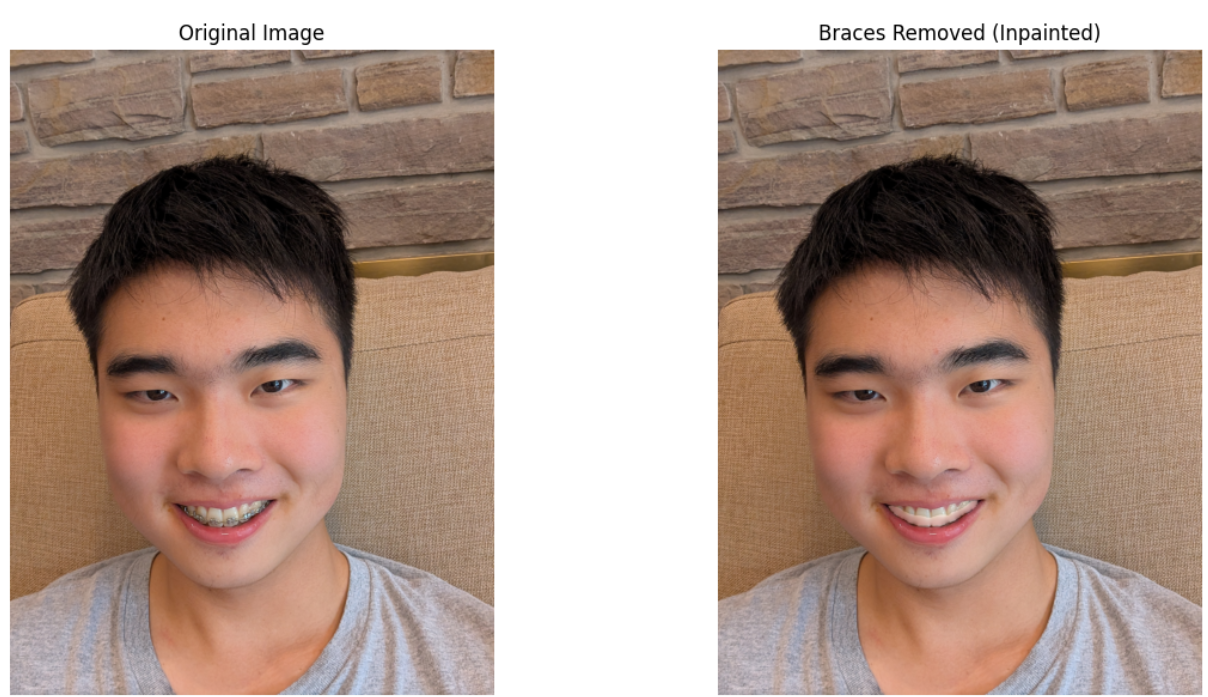
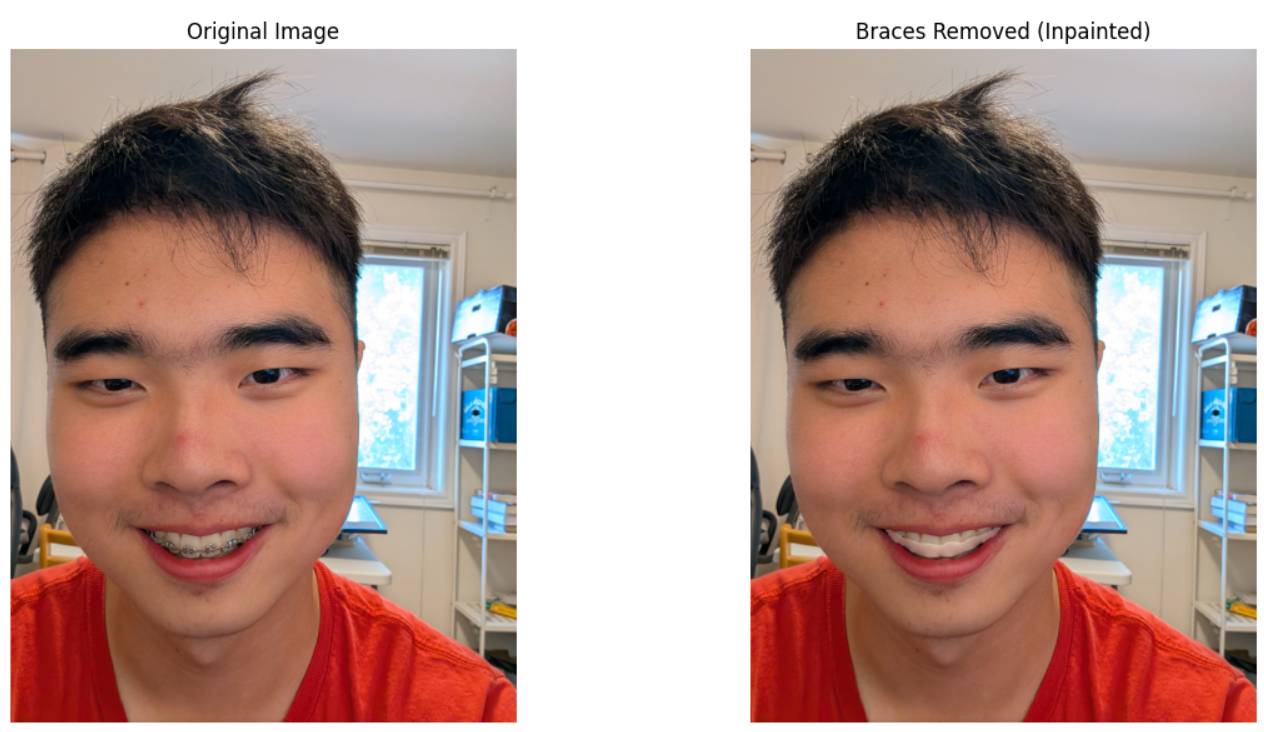
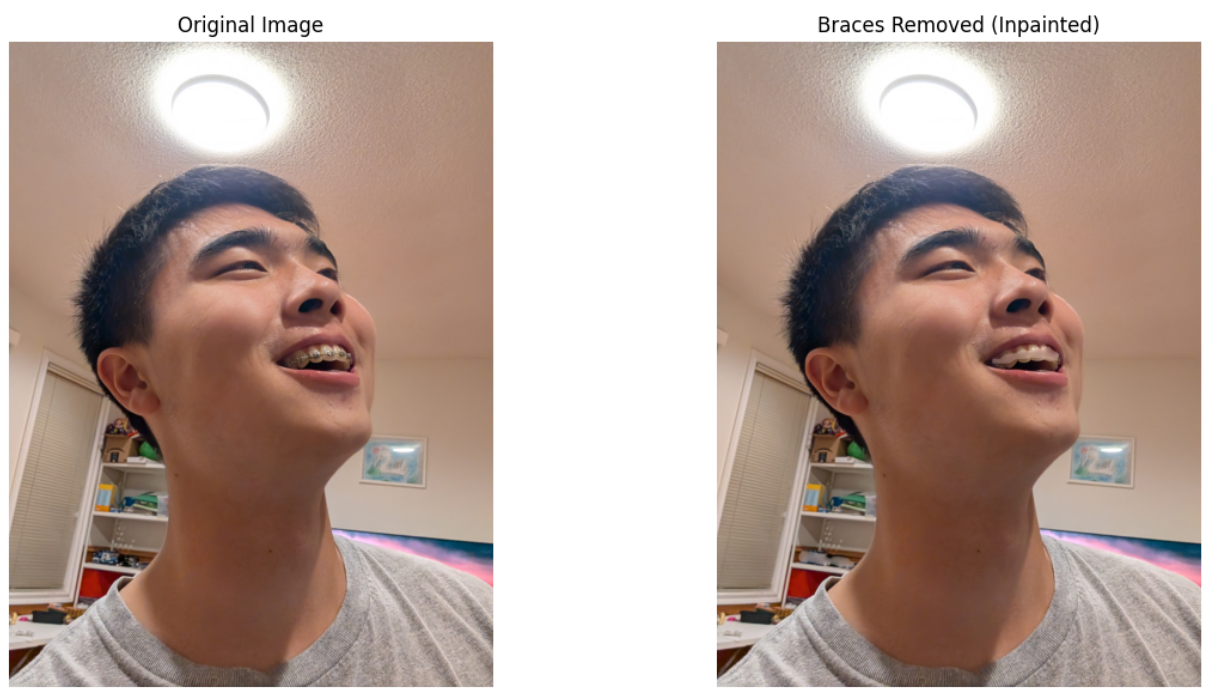
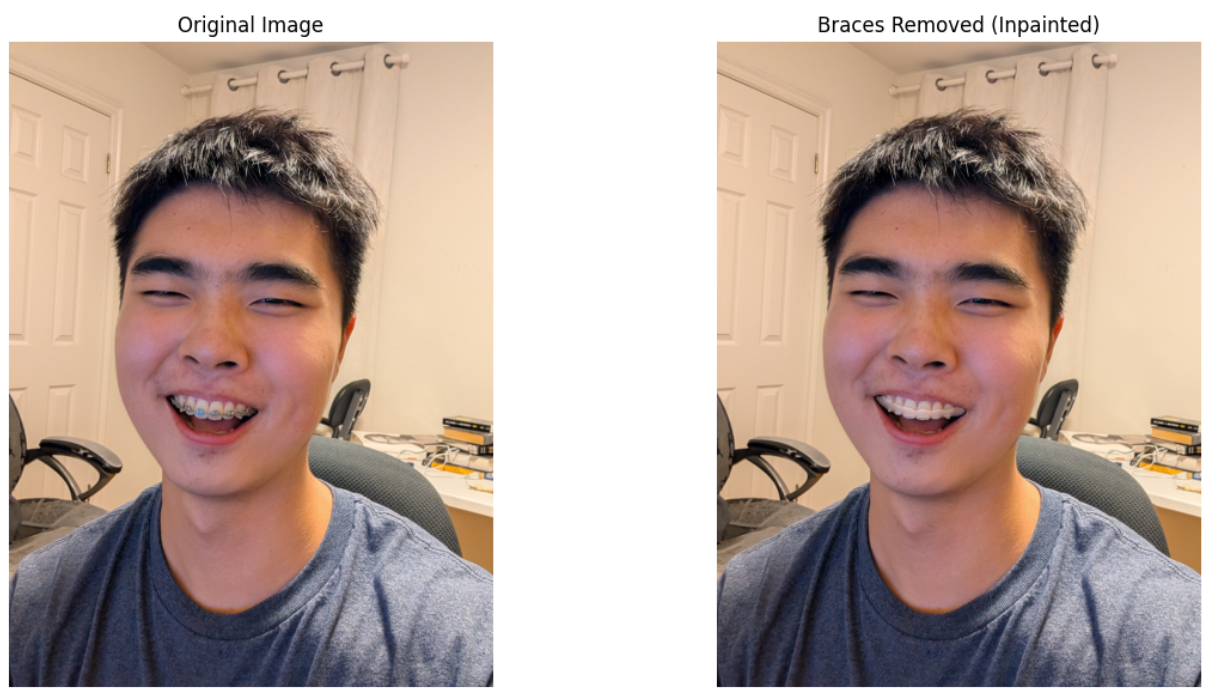